# Scene Class Example

The `Scene` class is a way to work with multiple targets near each other in a "Scene". You will need to supply the scene with the PSF model you'd like to use.

In [1]:
from pandorapsf import Scene, PSF

In [2]:
p = PSF.from_name("VISDA")

In [3]:
p

2D PSF Model [row, column]

We'll need some locations at which to place some PSFs. We can randomly generate some locations

In [4]:
import numpy as np
nsources = 1280
r, c = np.random.uniform(-1024, 1024, (2, nsources))

<div class="admonition note">
    <p class="admonition-title">Note</p>
    <p>
        Note here that the source positions are normalized to zero. This is because in `pandorapsf` row=0 column=0 is the middle of the detector. 
    </p>
</div>

In [5]:
s = Scene(locations=np.asarray([r, c]).T, psf=p, shape=(2048, 2048), corner=(-1024, -1024))

In [6]:
s

Scene Object [2D PSF Model [row, column]] Detector Size: (2048, 2048), ntargets: 1280

We've now created our scene object. We can use the `model` class method to model an image. We'll have to pass in some fluxes to model, we can make those randomly.

In [7]:
flux = 10**np.random.normal(0, 0.4, nsources)

In [8]:
images = s.model(flux)

This has modeled an image stack for us

In [9]:
images.shape

(1, 2048, 2048)

We've only passed in a single flux, so this has given us one image in time. We could create flux at many times and pass those in to create more images.

In [10]:
ntimes = 10
flux = 10**np.random.normal(0, 0.4, (nsources, ntimes))

In [11]:
images = s.model(flux)

In [12]:
images.shape

(10, 2048, 2048)

Let's plot one of the images to see what it loks like

In [13]:
import matplotlib.pyplot as plt

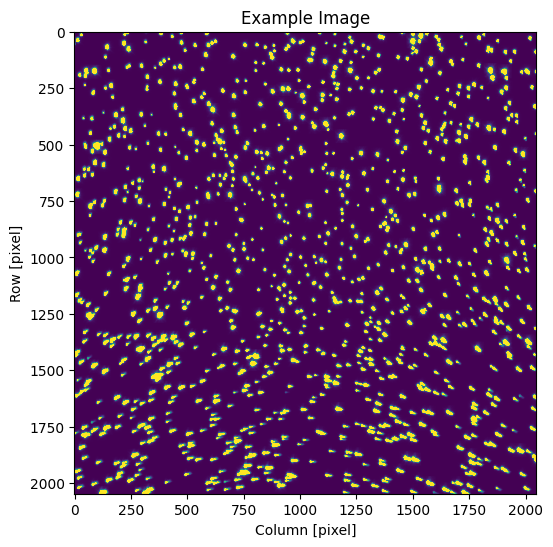

In [14]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(images[0], vmin=0, vmax=0.001)
ax.set(xlabel='Column [pixel]', ylabel='Row [pixel]', title='Example Image');

We may want to also change the position of the scene as a function of time. 

In [15]:
ntimes = 3
flux = 10**np.random.normal(0, 0.4, (nsources, ntimes))
delta_position = np.random.uniform(-300, 300, (2, ntimes))

In [16]:
images = s.model(flux, delta_pos=delta_position)

Modeling Pixel Positions: 100%|███████████████████| 3/3 [00:01<00:00,  2.67it/s]


Including a delta position within the scene model enables the scene to be moved in each time step. This uses gradients to approximate the PRF after a subpixel shift.

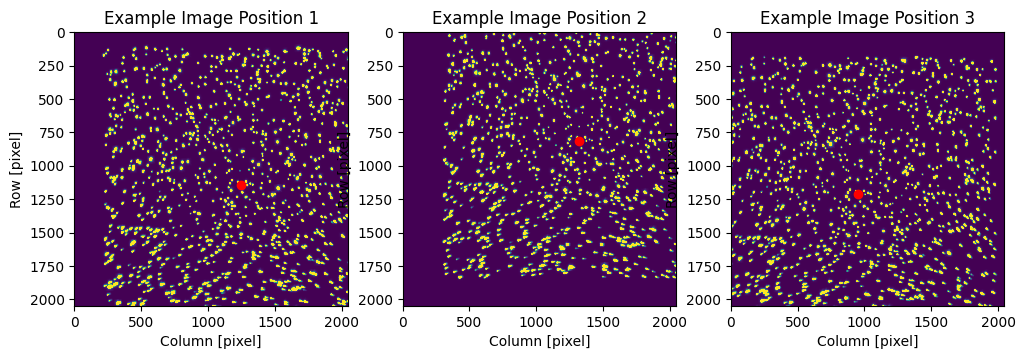

In [17]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(images[0], vmin=0, vmax=0.001)
ax[0].scatter(1024 + delta_position[1, 0], 1024 + delta_position[0, 0], c='r')
ax[1].imshow(images[1], vmin=0, vmax=0.001)
ax[1].scatter(1024 + delta_position[1, 1], 1024 + delta_position[0, 1], c='r')
ax[2].imshow(images[2], vmin=0, vmax=0.001)
ax[2].scatter(1024 + delta_position[1, 2], 1024 + delta_position[0, 2], c='r')
ax[0].set(xlabel='Column [pixel]', ylabel='Row [pixel]', title='Example Image Position 1');
ax[1].set(xlabel='Column [pixel]', ylabel='Row [pixel]', title='Example Image Position 2');
ax[2].set(xlabel='Column [pixel]', ylabel='Row [pixel]', title='Example Image Position 3');

Adding in position shifts will slow down the modeling of the image.

## Making higher fidelity simulations

There is a trade in simulating images between speed of computation and accuracy of simulations. 

You are able to tune the the fidelity of the simulations using the `scale` parameter.

In [18]:
nsources = 30
r, c = np.random.uniform(-50, 50, (2, nsources))
flux = 10**np.random.normal(0, 0.4, nsources)

In [19]:
scale = 1
p = PSF.from_name("VISDA", scale=scale)
s = Scene(locations=np.asarray([r, c]).T,
          psf=p,
          shape=(100, 101),
          corner=(-50, -50), 
          scale=scale)

Here I have created a simulation of 100 x 101 size image, with `scale=1`. Let's look at the image this creates

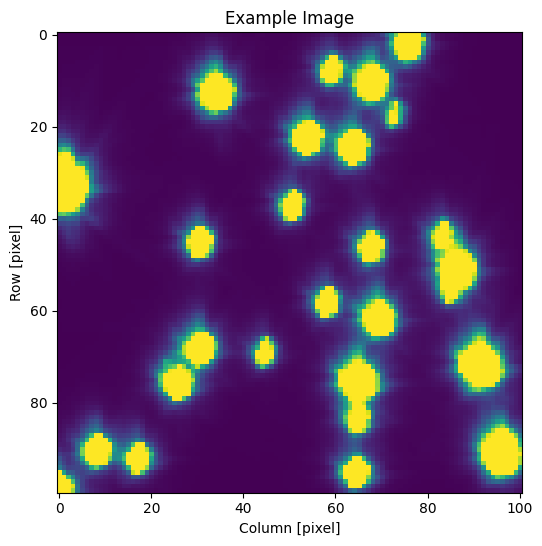

In [20]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(s.model(flux)[0], vmin=0, vmax=0.01)
ax.set(xlabel='Column [pixel]', ylabel='Row [pixel]', title='Example Image');

Here we have used a PRF evaluated at the pixel resolution. Let's double the scale

In [21]:
scale = 2
p = PSF.from_name("VISDA", scale=scale)
s = Scene(locations=np.asarray([r, c]).T,
          psf=p,
          shape=(100, 101),
          corner=(-50, -50), 
          scale=scale)

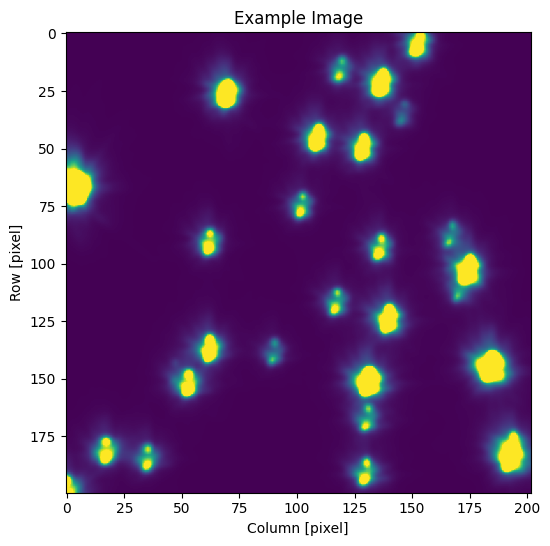

In [22]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(s.model(flux)[0], vmin=0, vmax=0.01)
ax.set(xlabel='Column [pixel]', ylabel='Row [pixel]', title='Example Image');

This has now created an image with 2x the dimensions, with a PSF that is 2x wider. This is slower to evaluate, but is higher fidelity. We may want to calculate the image in this higher resolution space and then downsample back to the image space, which we can do using the `downsample` keyword inside `model`.

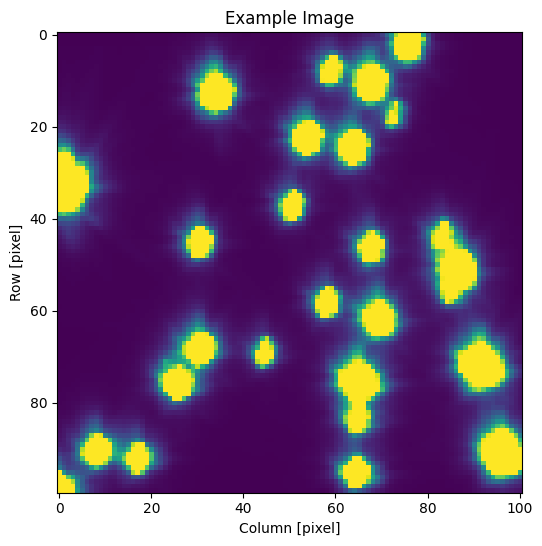

In [23]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(s.model(flux, downsample=True)[0], vmin=0, vmax=0.01)
ax.set(xlabel='Column [pixel]', ylabel='Row [pixel]', title='Example Image');

This image looks a lot like the first, but is a more accurate model of the scene. We can time the functions to see how much of a slow down we suffer for this higher resolution

In [24]:
scale = 1
p = PSF.from_name("VISDA", scale=scale)
s_lowres = Scene(locations=np.asarray([r, c]).T,
          psf=p,
          shape=(100, 101),
          corner=(-50, -50), 
          scale=scale)

scale = 2
p = PSF.from_name("VISDA", scale=scale)
s_highres = Scene(locations=np.asarray([r, c]).T,
          psf=p,
          shape=(100, 101),
          corner=(-50, -50), 
          scale=scale)

In [25]:
%%timeit
s_lowres.model(flux)

69.3 µs ± 2.3 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [26]:
%%timeit
s_highres.model(flux, downsample=True)

402 µs ± 34.7 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


You should decide based on your application whether you are interested in speed or accuracy.